In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import os
from torch.backends import cudnn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
import pickle
from skimage import io
import numpy as np
from PIL import Image
import scipy.misc
from torch.autograd import Variable
from torch import optim
from time import time
from tqdm import trange

In [2]:
# data_loader




class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
    def __str__(self):
        return str(self.__dict__)
    
    
    
# model hyper-parameters
config = Namespace(image_size=64, 
                   g_conv_dim=64, 
                   d_conv_dim=64, 
                   use_reconst_loss=True,
                   
                   train_iters=20001, 
                   batch_size=64, 
                   num_workers=4, 
                   lr=0.0002,
                   beta1=0.5, 
                   beta2=0.999, 
                   
                   mode='train',
                   model_path='./models', 
                   sample_path='./samples',
                   anime_path='./anime',
                   real_path='./real',
                   log_step=10,
                   sample_step=500,
                  )



class FaceDataset(Dataset):

    def __init__(self, root_dir, name, transform=None, load=False):
        self.name = name
        self.root_dir = root_dir
        self.transform = transform
        if load:
            self.imgs, self.fnames = self.load()
        else:
            imgs = []
            self.fnames = []
            for i, fname in enumerate(os.listdir(root_dir)):
                if not i % 1000:
                    print(i)
                img_name = os.path.join(self.root_dir, fname)
                image = Image.open(img_name)
                if image.mode == 'RGB':
                    image = self.transform(image)
                    self.fnames.append(fname)
                    imgs.append(image)
            self.fnames = np.array(self.fnames)
            self.imgs = torch.stack(imgs)
            self.save()

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        return self.imgs[idx]
    
    def save(self):
        np.save(self.name+"_fn.npy", self.fnames)
        torch.save(self.imgs, self.name+"_im")

    
    def load(self):
        return torch.load(self.name+"_im"), np.load(self.name+"_fn.npy")

transform = transforms.Compose([
                transforms.Scale((config.image_size, config.image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

real = FaceDataset(root_dir=config.real_path, name="real_data", transform=transform, load=True)
anime = FaceDataset(root_dir=config.anime_path, name="anime_data", transform=transform, load=True)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [3]:
real_loader = DataLoader(dataset=real, 
                         batch_size=config.batch_size,
                         shuffle=True,
                         num_workers=config.num_workers)

anime_loader = DataLoader(dataset=anime,
                         batch_size=config.batch_size,
                         shuffle=True,
                         num_workers=config.num_workers)

In [4]:
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

class G(nn.Module):
    def __init__(self, conv_dim=64):
        super(G, self).__init__()
        # encoding blocks
        self.conv1 = conv(3, conv_dim, 6, pad=2)
        self.conv2 = conv(conv_dim, conv_dim*2, 6, pad=2)
        
        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 5, 1, 2)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 5, 1, 2)
        
        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 6, pad=2)
        self.deconv2 = deconv(conv_dim, 3, 6, pad=2, bn=False)
        
        self.do = nn.Dropout(0.3)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 32, 32)
#         out = self.do(out)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 16, 16)
        
        encoded = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
#         out = self.do(out)
        out = F.leaky_relu(self.conv4(encoded), 0.05)    # ( " )
        
        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 32, 32)
#         out = self.do(out)
        out = F.tanh(self.deconv2(out))              # (?, 3, 64, 64)
        return out, encoded

    
class D(nn.Module):
    def __init__(self, conv_dim=64, in_dim=3, out_kernel_size=4):
        super(D, self).__init__()
        self.conv1 = conv(in_dim, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 1
        self.fc = conv(conv_dim*4, n_out, out_kernel_size, 1, 0, False)
        self.do = nn.Dropout(0.3)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 32, 32)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 16, 16)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 8, 8)
#         out = self.do(out)
        out = self.fc(out).squeeze()
        out = F.sigmoid(out)
        return out

In [23]:
class Solver(object):
    def __init__(self, config, real_loader, anime_loader):
        self.real_loader = real_loader
        self.anime_loader = anime_loader
        self.g12 = None
        self.g21 = None
        self.d1 = None
        self.d2 = None
        self.d_emb = None
        self.g_optimizer = None
        self.d_optimizer = None
        self.use_reconst_loss = config.use_reconst_loss
        self.beta1 = config.beta1
        self.beta2 = config.beta2
        self.g_conv_dim = config.g_conv_dim
        self.d_conv_dim = config.d_conv_dim
        self.train_iters = config.train_iters
        self.batch_size = config.batch_size
        self.lr = config.lr
        self.log_step = config.log_step
        self.sample_step = config.sample_step
        self.sample_path = config.sample_path
        self.model_path = config.model_path
        self.build_model()
        
    def build_model(self):
        """Builds a generator and a discriminator."""
        self.g12 = G(conv_dim=self.g_conv_dim)
        self.g21 = G(conv_dim=self.g_conv_dim)
        self.d1 = D(conv_dim=self.d_conv_dim)
        self.d2 = D(conv_dim=self.d_conv_dim)
        self.d_emb = D(conv_dim=2*self.d_conv_dim, in_dim=128, out_kernel_size=2)
        g_params = list(self.g12.parameters()) + list(self.g21.parameters())
        d_params = list(self.d1.parameters()) + list(self.d2.parameters()) + list(self.d_emb.parameters())
        
        self.g_optimizer = optim.Adam(g_params, self.lr, [self.beta1, self.beta2])
        self.d_optimizer = optim.Adam(d_params, self.lr, [self.beta1, self.beta2])
        
        if torch.cuda.is_available():
            self.g12.cuda()
            self.g21.cuda()
            self.d1.cuda()
            self.d2.cuda()
            self.d_emb.cuda()
    
    def merge_images(self, sources, targets, k=10):
        _, _, h, w = sources.shape
        if k == 0:
            rows=1
        else:
            rows = int(np.sqrt(sources.shape[0]))
        merged = np.zeros([3, rows*h, rows*w*2])
        for idx, (s, t) in enumerate(zip(sources, targets)):
            merged[:, (idx // rows)*h:((idx // rows)+1)*h, 2*(idx % rows)*w:(2*(idx % rows)+1)*w] = s
            merged[:, (idx // rows)*h:((idx // rows)+1)*h, (2*(idx % rows)+1)*w:(2*(idx % rows)+2)*w] = t
        return merged.transpose(1, 2, 0)
    
    def to_var(self, x):
        """Converts numpy to variable."""
        if torch.cuda.is_available():
            x = x.cuda()
        return Variable(x).cuda()
    
    def to_data(self, x):
        """Converts variable to numpy."""
        if torch.cuda.is_available():
            x = x.cpu()
        return x.data.numpy()
    
    def reset_grad(self):
        """Zeros the gradient buffers."""
        self.g_optimizer.zero_grad()
        self.d_optimizer.zero_grad()

    def plot_history(self, *history):
        if len(history[0]) <= 20:
            return
        for h, t in zip(history, ["d_anime_loss", "d_real_loss", "d_fake_anime_loss", "d_fake_real_loss", "g_loss12", "g_loss21"]):
            plt.figure()
            plt.title('{}'.format(t))
            plt.plot(h[20:], label='train', zorder=1)
            plt.xlabel('train steps')
            plt.legend(loc='best')
            plt.grid()
            plt.show()
    
    def train(self):
        real_iter = iter(self.real_loader)
        anime_iter = iter(self.anime_loader)
        iter_per_epoch = min(len(real_iter), len(anime_iter))
        
        # fixed anime and real for sampling

        fixed_real = self.to_var(real_iter.next()[:25])
        fixed_anime = self.to_var(anime_iter.next()[:25])
        
        ep = 0
        
        d_anime_loss_log, d_real_loss_log, d_fake_anime_loss_log, d_fake_real_loss_log, g_loss12_log, g_loss21_log = [], [], [], [], [], []
        
        for step in trange(self.train_iters+1):
            # reset data_iter for each epoch
            if (step+1) % iter_per_epoch == 0:
                ep+=1
                anime_iter = iter(self.anime_loader)
                real_iter = iter(self.real_loader)
            
            # load real and anime dataset
            real = real_iter.next() 
            real = self.to_var(real)
            anime = anime_iter.next() 
            anime = self.to_var(anime)

            
            #============ train D ============#
            
            # train with original images
            self.reset_grad()
            out = self.d1(anime)
            d1_loss = torch.mean((out - Variable(torch.from_numpy(np.random.uniform(low=0.8, size=out.shape)).float().cuda()))**2)
            
            out = self.d2(real)
            d2_loss = torch.mean((out - Variable(torch.from_numpy(np.random.uniform(low=0.8, size=out.shape)).float().cuda()))**2)
            
            d_anime_loss = d1_loss
            d_real_loss = d2_loss
            d_orig_loss = d1_loss + d2_loss
            d_orig_loss.backward()
            self.d_optimizer.step()
            
            # train with fake images
            self.reset_grad()
            fake_real, emb12 = self.g12(anime)
            out = self.d2(fake_real)
            d2_loss = torch.mean((out - Variable(torch.from_numpy(np.random.uniform(high=0.2, size=out.shape)).float().cuda()))**2)
            
            oute12 = self.d_emb(emb12)
            
            fake_anime, emb21 = self.g21(real)
            out = self.d1(fake_anime)
            d1_loss = torch.mean((out - Variable(torch.from_numpy(np.random.uniform(high=0.2, size=out.shape)).float().cuda()))**2)
            oute21 = self.d_emb(emb21)
            d_emb_loss = torch.mean((oute12-1)**2) + torch.mean(oute21**2)
            
            d_fake_anime_loss = d2_loss
            d_fake_real_loss = d1_loss
            d_fake_loss = d1_loss + d2_loss + d_emb_loss
            d_fake_loss.backward()
            self.d_optimizer.step()
            
            #============ train G ============#
            
            # train anime-real-anime cycle
            self.reset_grad()
            fake_real, emb12 = self.g12(anime)
            out = self.d2(fake_real)
            out_emb = self.d_emb(emb12)
            reconst_anime, _ = self.g21(fake_real)

            g_loss12 = torch.mean((out-1)**2) 
            g_loss12 += 0.5 * torch.mean(out_emb**2)
            if self.use_reconst_loss:
                g_loss12 += torch.mean((anime - reconst_anime)**2)

            g_loss12.backward()
            self.g_optimizer.step()

            # train real-anime-real cycle
            self.reset_grad()
            fake_anime, emb21 = self.g21(real)
            out = self.d1(fake_anime)
            out_emb = self.d_emb(emb21)
            reconst_real, _ = self.g12(fake_anime)
            g_loss21 = torch.mean((out-1)**2) 
            g_loss21 += 0.5 * torch.mean((out_emb-1)**2)
            if self.use_reconst_loss:
                g_loss21 += torch.mean((real - reconst_real)**2)

            g_loss21.backward()
            self.g_optimizer.step()
            
            # print the log info
            if (step+1) % self.log_step == 0:
                d_anime_loss_log.append(d_anime_loss.data[0])
                d_real_loss_log.append(d_real_loss.data[0])
                d_fake_anime_loss_log.append(d_fake_anime_loss.data[0])
                d_fake_real_loss_log.append(d_fake_real_loss.data[0])
                g_loss12_log.append(g_loss12.data[0])
                g_loss21_log.append(g_loss21.data[0])
                clear_output(True)
                self.plot_history(d_anime_loss_log, d_real_loss_log, d_fake_anime_loss_log, d_fake_real_loss_log, g_loss12_log, g_loss21_log)

            # save the sampled images
            if (step+1) % self.sample_step == 0:
                
                
                fake_real, _ = self.g12(fixed_anime)
                fake_anime, _ = self.g21(fixed_real)
                
                restored_anime, _ = self.g21(fake_real)
                restored_real, _ = self.g12(fake_anime)
                
                anime, fake_anime, restored_anime = self.to_data(fixed_anime), self.to_data(fake_anime), self.to_data(restored_anime)
                real, fake_real, restored_real = self.to_data(fixed_real), self.to_data(fake_real), self.to_data(restored_real)
                

#                 merged = self.merge_images(anime, fake_real)
#                 path = os.path.join(self.sample_path, 'sample-%d-a-r.png' %(step+1))
#                 io.imsave(path, merged)
#                 print ('saved %s' %path)
                
                merged = self.merge_images(real, fake_anime)
                path = os.path.join(self.sample_path, 'sample-%d-r-a.png' %(step+1))
                scipy.misc.imsave(path, merged)
                print ('saved %s' %path)

                merged = self.merge_images(real, restored_real)
                path = os.path.join(self.sample_path, 'sample-%d-r-r.png' %(step+1))
                scipy.misc.imsave(path, merged)
                print ('saved %s' %path)
            
                merged = self.merge_images(anime, restored_anime)
                path = os.path.join(self.sample_path, 'sample-%d-a-a.png' %(step+1))
                scipy.misc.imsave(path, merged)
                print ('saved %s' %path)
                
                merged = self.merge_images(anime, fake_real)
                path = os.path.join(self.sample_path, 'sample-%d-a-r.png' %(step+1))
                scipy.misc.imsave(path, merged)
                print ('saved %s' %path)
            
            if (step+1) % 5000 == 0:
                # save the model parameters for each epoch
                g12_path = os.path.join(self.model_path, 'g12-%d.pkl' %(step+1))
                g21_path = os.path.join(self.model_path, 'g21-%d.pkl' %(step+1))
                d1_path = os.path.join(self.model_path, 'd1-%d.pkl' %(step+1))
                d2_path = os.path.join(self.model_path, 'd2-%d.pkl' %(step+1))
                torch.save(self.g12.state_dict(), g12_path)
                torch.save(self.g21.state_dict(), g21_path)
                torch.save(self.d1.state_dict(), d1_path)
                torch.save(self.d2.state_dict(), d2_path)

In [24]:
config.train_iters=150001

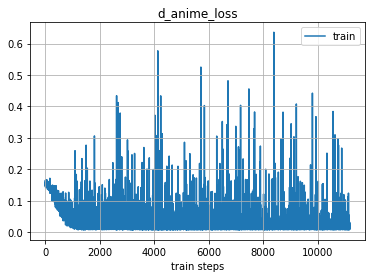

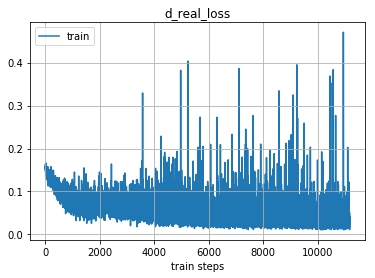

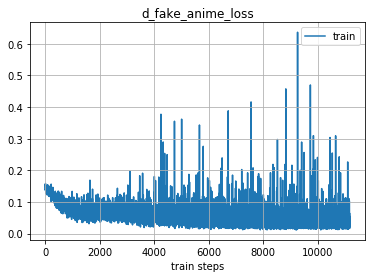

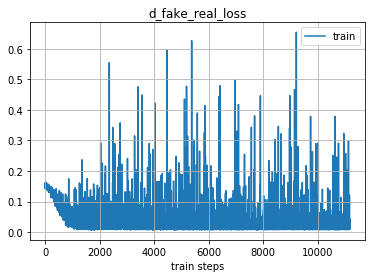

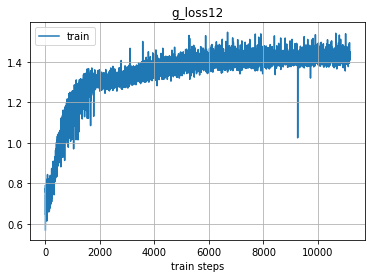

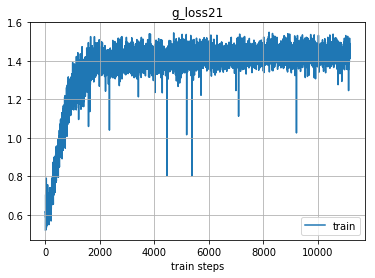

 75%|███████▍  | 111921/150002 [8:03:07<2:44:23,  3.86it/s]

In [ ]:
import sys

def str2bool(v):
    return v.lower() in ('true')

def main(config, real=None, anime=None):
    solver = Solver(config, real_loader, anime_loader)
    cudnn.benchmark = True 
    
    # create directories if not exist
    if not os.path.exists(config.model_path):
        os.makedirs(config.model_path)
    if not os.path.exists(config.sample_path):
        os.makedirs(config.sample_path)
    
    if config.mode == 'train':
        solver.train()
    elif config.mode == 'sample':
        solver.sample()


t = time()
main(config, real, anime)
print(time()-t)

In [4]:
import imageio
with imageio.get_writer('./samples/res_ar.gif', mode='I', duration=0.5) as writer:
    for i, filename in enumerate(os.listdir('./samples/')):
        if "a-r" in filename and not i % 5:
            image = imageio.imread('./samples/' + filename)
            writer.append_data(image)

In [6]:
import imageio
old_im=None

def face_dif(old, im):
    return np.linalg.norm(np.array(old_im)[15:60, 75:115].astype(np.float) - np.array(image)[15:60, 75:115].astype(np.float))

with imageio.get_writer('./samples/res_ra.gif', mode='I', duration=0.5) as writer:
    for i, filename in enumerate(os.listdir('./samples/')):
        if "r-a" in filename and not i % 5:
            image = imageio.imread('./samples/' + filename)
            if not old_im is None:
#                 print(face_dif(old_im, image))
#                 if 1500 <= face_dif(old_im, image) <= 3000:
                writer.append_data(old_im)
            old_im = image
#             writer.append_data(image)

In [39]:
g12 = G(conv_dim=64)
g21 = G(conv_dim=64)
d1 = D(conv_dim=64)
d2 = D(conv_dim=64)
real_loader, anime_loader = get_loader(config, load=True)
real_iter = iter(real_loader)
anime_iter = iter(anime_loader)
solver = Solver(config, real_loader, anime_loader)
# fixed anime and real for sampling

fixed_real = solver.to_var(real_iter.next()[:25])
fixed_anime = solver.to_var(anime_iter.next()[:25])

step=35000
# if step ==0:
#     continue
# save the model parameters for each epoch
g12_path = os.path.join(solver.model_path, 'g12-%d.pkl' %(step))
g21_path = os.path.join(solver.model_path, 'g21-%d.pkl' %(step))
d1_path = os.path.join(solver.model_path, 'd1-%d.pkl' %(step))
d2_path = os.path.join(solver.model_path, 'd2-%d.pkl' %(step))

g12.load_state_dict(torch.load(g12_path))
g21.load_state_dict(torch.load(g21_path))
d1.load_state_dict(torch.load(d1_path))
d2.load_state_dict(torch.load(d2_path))
g12.cuda()
g21.cuda()
d1.cuda()
d2.cuda()
    
    
    
fake_real = g12(fixed_anime)
fake_anime = g21(fixed_real)

anime, fake_anime = solver.to_data(fixed_anime), solver.to_data(fake_anime)
real , fake_real = solver.to_data(fixed_real), solver.to_data(fake_real)

merged = solver.merge_images(anime, fake_real,k=0)
path = os.path.join(config.sample_path, 'sample-%d-a-r.png' %(step+1))
io.imsave("/home/vary10/notebooks/k.jpg", merged)
print ('saved %s' %path)

merged = solver.merge_images(real, fake_anime,k=0)
path = os.path.join(config.sample_path, 'sample-%d-r-a.png' %(step+1))
scipy.misc.imsave("/home/vary10/notebooks/a.jpg", merged)
print ('saved %s' %path)




/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
(3, 320, 640)
[0, 64, 0, 64]
(3, 64, 64) (3, 64, 64)
[0, 64, 128, 192]
(3, 64, 64) (3, 64, 64)
[0, 64, 256, 320]
(3, 64, 64) (3, 64, 64)
[0, 64, 384, 448]
(3, 64, 64) (3, 64, 64)
[0, 64, 512, 576]
(3, 64, 64) (3, 64, 64)
[64, 128, 0, 64]
(3, 64, 64) (3, 64, 64)
[64, 128, 128, 192]
(3, 64, 64) (3, 64, 64)
[64, 128, 256, 320]
(3, 64, 64) (3, 64, 64)
[64, 128, 384, 448]
(3, 64, 64) (3, 64, 64)
[64, 128, 512, 576]
(3, 64, 64) (3, 64, 64)
[128, 192, 0, 64]
(3, 64, 64) (3, 64, 64)
[128, 192, 128, 192]
(3, 64, 64) (3, 64, 64)
[128, 192, 256, 320]
(3, 64, 64) (3, 64, 64)
[128, 192, 384, 448]
(3, 64, 64) (3, 64, 64)
[128, 192, 512, 576]
(3, 64, 64) (3, 64, 64)
[192, 256, 0, 64]
(3, 64, 64) (3, 64, 64)

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


saved ./samples/sample-35001-a-r.png
(3, 320, 640)
[0, 64, 0, 64]
(3, 64, 64) (3, 64, 64)
[0, 64, 128, 192]
(3, 64, 64) (3, 64, 64)
[0, 64, 256, 320]
(3, 64, 64) (3, 64, 64)
[0, 64, 384, 448]
(3, 64, 64) (3, 64, 64)
[0, 64, 512, 576]
(3, 64, 64) (3, 64, 64)
[64, 128, 0, 64]
(3, 64, 64) (3, 64, 64)
[64, 128, 128, 192]
(3, 64, 64) (3, 64, 64)
[64, 128, 256, 320]
(3, 64, 64) (3, 64, 64)
[64, 128, 384, 448]
(3, 64, 64) (3, 64, 64)
[64, 128, 512, 576]
(3, 64, 64) (3, 64, 64)
[128, 192, 0, 64]
(3, 64, 64) (3, 64, 64)
[128, 192, 128, 192]
(3, 64, 64) (3, 64, 64)
[128, 192, 256, 320]
(3, 64, 64) (3, 64, 64)
[128, 192, 384, 448]
(3, 64, 64) (3, 64, 64)
[128, 192, 512, 576]
(3, 64, 64) (3, 64, 64)
[192, 256, 0, 64]
(3, 64, 64) (3, 64, 64)
[192, 256, 128, 192]
(3, 64, 64) (3, 64, 64)
[192, 256, 256, 320]
(3, 64, 64) (3, 64, 64)
[192, 256, 384, 448]
(3, 64, 64) (3, 64, 64)
[192, 256, 512, 576]
(3, 64, 64) (3, 64, 64)
[256, 320, 0, 64]
(3, 64, 64) (3, 64, 64)
[256, 320, 128, 192]
(3, 64, 64) (3, 64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


saved ./samples/sample-35001-r-a.png


In [34]:
import os
from PIL import Image
import numpy as np
# i = 0
# for folder in os.listdir('/home/vary10/Downloads/danbooru_faces/'):
#     fnames = os.listdir('/home/vary10/Downloads/danbooru_faces/' + folder)
#     idx = np.random.choice(np.arange(len(fnames)), replace=False, size=len(fnames) * 10 // 88 + 1)
#     for j in idx:
#         i+=1
#         im = Image.open('/home/vary10/Downloads/danbooru_faces/' + folder+"/"+fnames[j])
#         os.rename('/home/vary10/Downloads/danbooru_faces/' + folder+"/"+fnames[j], '/home/vary10/notebooks/anime_faces/'+folder+fnames[j])
#         if not i % 1000:
#             print(i)

In [43]:
from PIL import Image
import numpy as np
import os
i = 0
for folder in os.listdir('/home/vary10/Downloads/danbooru_faces/'):
    fnames = os.listdir('/home/vary10/Downloads/danbooru_faces/' + folder)
    idx = np.random.choice(np.arange(len(fnames)), replace=False, size=len(fnames) * 100 // 385 + 1)
    for j in idx:
#         im = Image.open('/home/vary10/Downloads/danbooru_faces/' + folder+"/"+fnames[j])
        os.rename('/home/vary10/Downloads/danbooru_faces/' + folder+"/"+fnames[j], './anime/'+folder+fnames[j])
        i += 1
        if not i % 1000:
            print(i)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000


In [5]:
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage.filters import gaussian
# im = Image.open('/home/vary10/Downloads/danbooru_faces/.sin/2641142_1.jpg')

In [ ]:
im = io.imread("./anime_faces/444237.jpg")

In [ ]:
im

In [ ]:
plt.imshow(np.swapaxes(np.swapaxes(im,1, 2),1,2))
plt.show()

In [11]:
im = Image.open("./anime_faces/77gl2377650_1.jpg")

In [4]:
import shutil
from skimage.transform import resize

In [21]:
fn = os.listdir("./real/")
for n in fn:
    if "chec" in n:
        continue
    im = io.imread("./real/"+n)
    if im.shape[0]>400:
        im = resize(im, (64,64))
        io.imsave("./real/"+n, im)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [18]:
def output_calc(n, k, s, p, deconv=False):
    r = 0
    if not deconv:
        while n + 2 * p >= k:
            n -= s
            r += 1
    else:
        while n > 0:
            n -= 1
            r += s
        
    print(r)

In [24]:
output_calc(2, 4, 2, 1)

1


In [21]:
files = np.fromfile("/home/vary10/Downloads/Anno/list_attr_celeba.txt", sep="\r")

In [22]:
files.shape

(2,)

In [23]:
files

array([2.02599e+05, 5.00000e+00])

In [2]:
import pandas as pd

In [24]:
s = open("/home/vary10/Downloads/Anno/list_attr_celeba.txt").read()
s= s.replace("  ", " ")

In [25]:
s= s.replace(" ", ",")

In [20]:
s = s.split("\n")

In [23]:
s[1]

'000001.jpg -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1 -1  1'

In [26]:
f = open("/home/vary10/Downloads/Anno/list_attr_celeba.txt", "w")

In [27]:
print(s, file=f)

In [28]:
files = pd.read_table("/home/vary10/Downloads/Anno/list_attr_celeba.txt", sep=",")

In [35]:
females = files["name"][files.Male == -1].values

In [36]:
for fname in females:
    os.rename("/home/vary10/Downloads/CelebA/Img/img_align_celeba/"+fname, "/home/vary10/notebooks/DL/Project/real/"+fname)